In [1]:
#===============================================================================================
#HPM
#===============================================================================================
 
from gurobipy import *
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt



# === Load dataset ===

# Load only the CUSTOMER section of the text file
data = pd.read_fwf("RC104_25.txt", skiprows=8, header=None)
data.columns = ["CUST_NO", "XCOORD", "YCOORD", "DEMAND", "READY_TIME", "DUE_DATE", "SERVICE_TIME"]


# Load data from previous period
data_pre = pd.read_fwf("RC103_25.txt", skiprows=8, header=None)
data_pre.columns = ["CUST_NO", "XCOORD", "YCOORD", "DEMAND", "READY_TIME", "DUE_DATE", "SERVICE_TIME"]

# === Sets ===
V = list(range(25))  # 25 vehicles
C = list(range(1, len(data)))  # Customers (1 to n), excluding depot (0)
N = list(range(len(data)))  # All nodes including depot

# === Parameters ===
dc = data['DEMAND'].tolist()
dc[0] = 0  # Depot demand = 0
dc_pre = data_pre['DEMAND'].tolist()
dc_pre[0] = 0  # Depot demand = 0
coords = list(zip(data['XCOORD'], data['YCOORD']))
ai = data['READY_TIME'].tolist()
bi = data['DUE_DATE'].tolist()
si = data['SERVICE_TIME'].tolist()

# Problem parameters
cij = 30
delta = 0.17        #https://progresschamber.org/wp-content/uploads/2024/06/Chamber-of-Progress-Efficiency-and-Emissions-Impact-of-Last-Mile-Online-Delivery-in-the-US.pdf
lambda_v = 200
pi = 10
theta = 0.7
mv = 100000
cv = 100
hv = 15
ev = 0.1
cf = 0.5                                                                                        
fv = 0.1
M = 1000000
w1, w2, w3 = 1, 1, 1  # weight for objectives

dc_rev = [round(d * delta) for d in dc_pre]  # Integer reverse demand!!!!

# === Distance matrix ===
t = np.zeros((len(N), len(N)))
for i in N:
    for j in N:
        t[i][j] = math.hypot(coords[i][0] - coords[j][0], coords[i][1] - coords[j][1])

# === Build model function ===
def build_base_model():
    m = Model()
    x = m.addVars(N, N, V, vtype=GRB.BINARY, name="x")
    z = m.addVars(N, V, vtype=GRB.BINARY, name="z")
    y = m.addVars(V, vtype=GRB.BINARY, name="y")  
    L0 = m.addVars(V, vtype=GRB.CONTINUOUS, name="L0")
    L = m.addVars(C, V, vtype=GRB.CONTINUOUS, name="L")
    alpha = m.addVars(N, V, vtype=GRB.CONTINUOUS, name="alpha")
    beta = m.addVars(V, vtype=GRB.CONTINUOUS, name="beta")
    Fc = m.addVars(C, V, vtype=GRB.CONTINUOUS, name="Fc")
    Rc = m.addVars(C, V, vtype=GRB.CONTINUOUS, name="Rc")
    Qd = m.addVars(C, vtype=GRB.CONTINUOUS, name="Qd")
    Qr = m.addVars(C, vtype=GRB.CONTINUOUS, name="Qr")

    # === Constraints ===
    
    # Vehicle only depart from the depot if it is used
    for v in V:
        m.addConstr(quicksum(x[0, j, v] for j in N) == y[v], name='depart_%s' % v)
        
    # Vehicle only depart from the depot if it is used
    for v in V:
        m.addConstr(quicksum(x[i, 0, v] for i in N) == y[v], name='finish_%s' % v)
    
    # Vehicle can be used or not
    for v in V:
        m.addConstr(y[v] <= 1, name='usedORnot_%s' % v)

    # Flow conservation, vehicle enter node and must exit
    for v in V:
        for i in N:
            m.addConstr(quicksum(x[i, j, v] for j in N) == quicksum(x[j, i, v] for j in N), name='FlowConservation_%s_%s' % (i, v))
    
    # No self-loop on customer nodes 
    for v in V:
        for i in C:
            m.addConstr(x[i, i, v] == 0, 
                    name='NoSelfLoop_%s_%s' % (i, v)) 

    # Each destination node is visited from nodes that previously visited
    for v in V:
        for i in N:
            m.addConstr(quicksum(x[i, j, v] for j in N) == z[i, v], 
                    name='Visit_%s_%s' % (i, v))     
    
    # Each customer node can be visited by different vehicles
    for i in C: 
        m.addConstr(quicksum(z[i, v] for v in V) >= 1, 
                name='MultiVisit_%s' % i)
    
    # Customer forward demand may not be fully satisfied in each period
    for i in C:
        m.addConstr(quicksum(Fc[i, v] for v in V) + Qd[i] >= dc[i], 
                name='forward_%s' % i)
    
    # Customer forward demand is not served if vehicle does not visit 
    for i in C:
        for v in V:
            m.addConstr(Fc[i,v] <= dc[i] * z[i,v], name=f"FlowIfVisit_{i}_{v}")

    # Customer reverse demand which depends on the forward demand of the previous period may not be fully satisfied in current period 
    for i in C:
        m.addConstr(quicksum(Rc[i, v] for v in V) + Qr[i] >= dc_rev[i], 
                name='return_%s' % i)
    
    # Customer reverse demand is not served if vehicle does not visit 
    for i in C:
        for v in V:
            m.addConstr(Rc[i,v] <= dc_rev[i] * z[i,v], name=f"ReturnIfVisit_{i}_{v}")

    # Each initial vehicle load is the accumulated demand of all customer points assigned to this vehicle
    for v in V:
        m.addConstr(L0[v] >= quicksum(Fc[i, v] for i in C), 
                name='startload_%s' % v)
    
    # Ensure the load balance of vehicles after they visit each customer point on their route
    for v in V:
        for i in C:
            for j in C:
                if i != j:
                    m.addConstr(L[j, v] >= L[i, v] - Fc[j, v] + Rc[j, v] - M * (1 - x[i, j, v]), name='otherload_%s_%s_%s' % (i, j, v))
    
    # The initial vehicle load doesn't exceed capacity of vehicle
    for v in V:
        m.addConstr(L0[v] <= lambda_v, 
                name='startcap_%s' % v)
    
    # The vehicle load after serving each customer doesn't exceed capacity of vehicle
    for v in V:
        for i in C:
            m.addConstr(L[i, v] <= lambda_v * z[i, v], 
                name='othercap_%s_%s' % (i, v))

    # Start of service time of destination node is after origin node and service duration    
    for v in V:
        for i in N:
            for j in C:
                m.addConstr(alpha[j, v] >= alpha[i, v] + si[i] + t[i][j] - M * (1 - x[i, j, v]), name='starttime_%s_%s_%s' % (i, j, v))
    
    # Time window constraints start of service time inside time window
    for v in V:
        for i in N:
            m.addConstr(alpha[i, v] >= ai[i] * z[i, v], 
                    name='EarliestStart_%s_%s' % (i, v)) 
            m.addConstr(alpha[i, v] <= bi[i] + M * (1 - z[i, v]), 
                    name='LatestStart_%s_%s' % (i, v)) 
    
    # Total duration that each vehicle finishes all services
    for v in V:
        m.addConstr(beta[v] == quicksum(t[i][j] * x[i, j, v] for i in N for j in C) + quicksum(si[i] * x[i, j, v] for i in C for j in C), 
                name='totalhour_%s' % v)
    
    # The maximum allowed transportation duration limit for each vehicle
    for v in V  :
        m.addConstr(beta[v] <= mv, 
                name='maxhour_%s' % v)

    return m, x, y, z, alpha, beta, Qd, Qr,Fc,Rc

In [2]:
# === Solve single-objective functions ===
def solve_feco_best():
    m, x, y, z, alpha, beta, Qd, Qr,Fc,Rc = build_base_model()
    Feco = quicksum(hv * beta[v] + cv * y[v] for v in V) + \
           quicksum(t[i][j] * x[i, j, v] * (cf * fv + cij) for i in N for j in N for v in V if i != j) + \
           pi * quicksum(Qd[i] + (1 - theta) * Qr[i] for i in C)
    m.setObjective(Feco, GRB.MINIMIZE)
    m.Params.timeLimit = 900
    m.update()
    m.write('eco25.lp')
    m.optimize()
    m.write('eco25.sol')
    return m.objVal

# === Retrieve best values ===
Feco_best = solve_feco_best()

print("\n=== Best Objective Values ===")
print(f"Best Economic Cost (Feco_best): {Feco_best:.4f}")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-20
Set parameter TimeLimit to value 900
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 36600 rows, 20200 columns and 199350 nonzeros
Model fingerprint: 0x6caf703a
Variable types: 2625 continuous, 17575 integer (17575 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [3e+00, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 2925 rows and 2400 columns
Presolve time: 1.61s
Presolved: 33675 rows, 17800 columns, 314150 nonzeros
Variable types: 2550 continuous, 15250 integer (15250 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time:

In [3]:
# === Solve single-objective functions ===

def solve_fenv_best():
    m, x, y, z, alpha, beta, Qd, Qr,Fc,Rc = build_base_model()
    Fenv = quicksum(ev * t[i][j] * x[i, j, v] for i in N for j in N for v in V if i != j)
    m.setObjective(Fenv, GRB.MINIMIZE)
    m.Params.timeLimit = 900
    m.update()
    m.write('env25.lp')
    m.optimize()
    m.write('env25.sol')
    return m.objVal

# === Retrieve best values ===
Fenv_best = solve_fenv_best()

print("\n=== Best Objective Values ===")
print(f"Best Environmental Impact (Fenv_best): {Fenv_best:.4f}")

Set parameter TimeLimit to value 900
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 36600 rows, 20200 columns and 199350 nonzeros
Model fingerprint: 0x25d7e601
Variable types: 2625 continuous, 17575 integer (17575 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [2e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 4200 rows and 3075 columns
Presolve time: 4.97s
Presolved: 32400 rows, 17125 columns, 277707 nonzeros
Variable types: 1875 continuous, 15250 integer (15250 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.4958229e+01 

In [4]:
# === Solve single-objective functions ===

def solve_fsoc_best():
    m, x, y, z, alpha, beta, Qd, Qr,Fc,Rc = build_base_model()
    Fsoc = quicksum(beta[v] for v in V)
    m.setObjective(Fsoc, GRB.MINIMIZE)
    m.Params.timeLimit = 900
    m.update()
    m.write('soc25.lp')
    m.optimize()
    m.write('soc25.sol')
    return m.objVal

# === Retrieve best values ===
Fsoc_best = solve_fsoc_best()

print("\n=== Best Objective Values ===")
print(f"Best Social Cost (Fsoc_best): {Fsoc_best:.4f}")

Set parameter TimeLimit to value 900
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 36600 rows, 20200 columns and 199350 nonzeros
Model fingerprint: 0x66631c84
Variable types: 2625 continuous, 17575 integer (17575 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 4200 rows and 3075 columns
Presolve time: 1.27s
Presolved: 32400 rows, 17125 columns, 277707 nonzeros
Variable types: 1875 continuous, 15250 integer (15250 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Use crossover to convert LP symmetric solution to basic s

In [2]:
# === Final full model ===
m, x, y, z, alpha, beta, Qd, Qr,Fc,Rc = build_base_model()

Feco_best = 18390.9967         # input best values as parameters !!!
Fenv_best = 30.4283            # input best values as parameters !!!
Fsoc_best = 411.1106          # input best values as parameters !!!

Feco = quicksum(hv * beta[v] + cv * y[v] for v in V) + \
       quicksum(t[i][j] * x[i, j, v] * (cf * fv + cij) for i in N for j in N for v in V if i != j) + \
       pi * quicksum(Qd[i] + (1 - theta) * Qr[i] for i in C)

Fenv = quicksum(ev * t[i][j] * x[i, j, v] for i in N for j in N for v in V if i != j)
Fsoc = quicksum(beta[v] for v in V)
Fsat = quicksum(theta * Qd[i] + (1 - theta) * Qr[i] for i in C)

F1 = w1 * (Feco - Feco_best) / Feco_best + \
     w2 * (Fenv - Fenv_best) / Fenv_best + \
     w3 * (Fsoc - Fsoc_best) / Fsoc_best

m.setObjectiveN(F1, index=0, priority=1, name="Sustainability")
m.setObjectiveN(Fsat, index=1, priority=0, name="CustomerSatisfaction")

# === Solve ===
m.update()
m.write('VRPmodel.lp')
m.Params.timeLimit = 1800
m.optimize()
m.write('VRPmodel.sol')


print("Final Objective Values:")
print("Feco:", Feco.getValue())
print("Fenv:", Fenv.getValue())
print("Fsoc:", Fsoc.getValue())
print("Customer Satisfaction (Fsat):", Fsat.getValue())

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-20
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 36600 rows, 20200 columns and 199350 nonzeros
Model fingerprint: 0x8b7e9eae
Variable types: 2625 continuous, 17575 integer (17575 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [2e-04, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------

No optimal solution found.

z[i, v] for Vehicle 3:
  Node 0: 1.00
  Node 1: 1.00
  Node 2: 1.00
  Node 3: 1.00
  Node 4: 1.00
  Node 5: 1.00
  Node 6: 1.00
  Node 7: 1.00
  Node 8: 1.00

z[i, v] for Vehicle 7:
  Node 0: 1.00
  Node 9: 1.00
  Node 10: 1.00
  Node 11: 1.00
  Node 12: 1.00
  Node 13: 1.00
  Node 14: 1.00
  Node 15: 1.00
  Node 16: 1.00
  Node 17: 1.00

z[i, v] for Vehicle 11:
  Node 0: 1.00
  Node 18: 1.00
  Node 19: 1.00
  Node 20: 1.00
  Node 21: 1.00
  Node 22: 1.00
  Node 23: 1.00
  Node 24: 1.00
  Node 25: 1.00

=== Forward Demand Fc[i, v] (Only Used Vehicles) ===
Vehicle 3 Forward Demand (Fc):
  Customer 1: 20.00
  Customer 2: 30.00
  Customer 3: 10.00
  Customer 4: 40.00
  Customer 5: 20.00
  Customer 6: 20.00
  Customer 7: 20.00
  Customer 8: 10.00

Vehicle 7 Forward Demand (Fc):
  Customer 9: 20.00
  Customer 10: 30.00
  Customer 11: 40.00
  Customer 12: 20.00
  Customer 13: 10.00
  Customer 14: 10.00
  Customer 15: 20.00
  Customer 16: 20.00
  Customer 17: 20.00

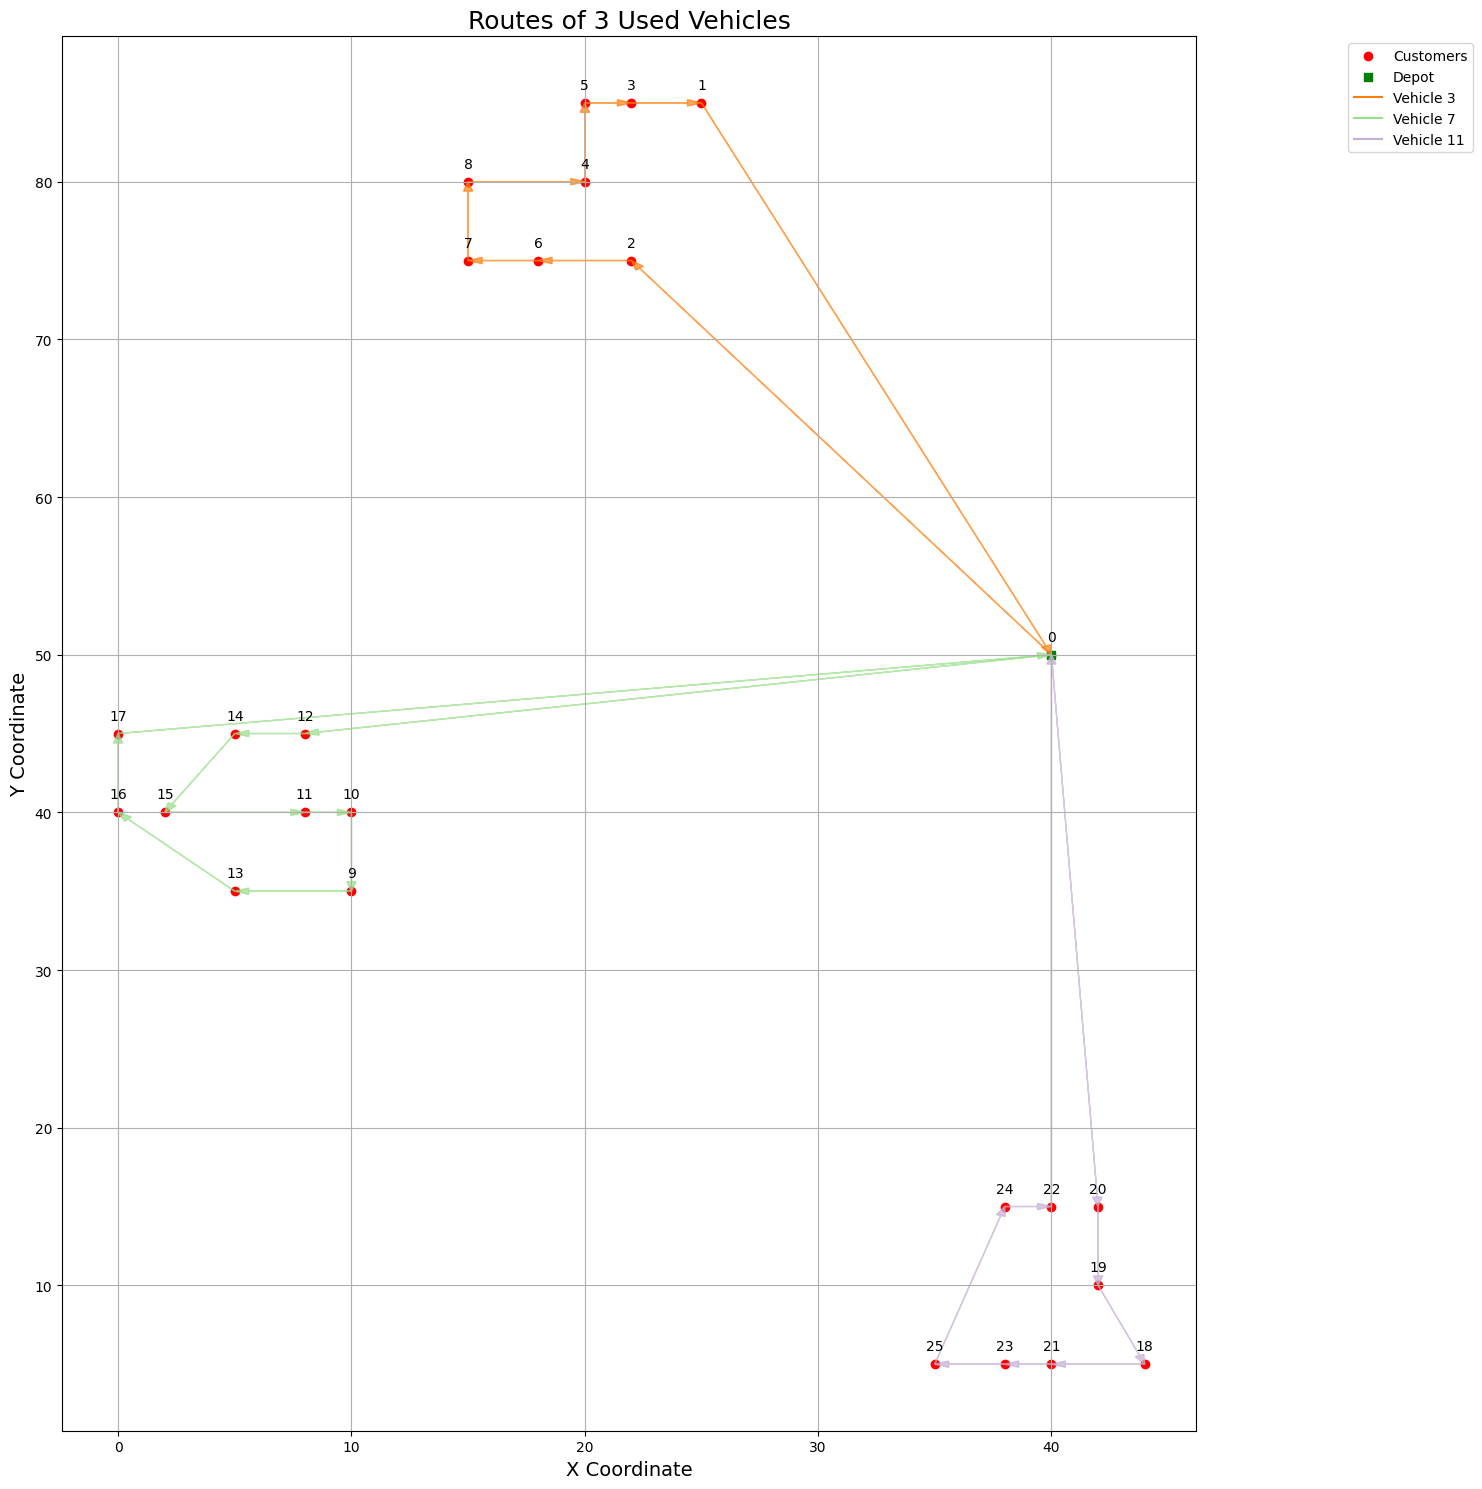

In [3]:
# === Output ===
if m.status == GRB.OPTIMAL:
    print("Optimal solution found.")
else:
    print("No optimal solution found.")

# === Routing matrix x[i,j,v], only for used vehicles ===
#arc_solution = m.getAttr('x', x)
#for v in V:
#    if y[v].X > 0.5:  # Only print for used vehicles
#        print(f"\nRouting matrix x[i,j,v] for Vehicle {v}:")
#        header = "     " + "   ".join([f"{j:>5}" for j in N])  
#        print(header)
#        print("-" * len(header))  
#        for i in N:
#            row = [f"{arc_solution[i, j, v]:>5.2f}" for j in N]  
#            print(f"{i:>5}  " + "   ".join(row))  

# === z[i, v] matrix ===
for v in V:
    if y[v].X > 0.5:
        print(f"\nz[i, v] for Vehicle {v}:")
        for i in N:
            if z[i, v].X > 1e-4:
                print(f"  Node {i}: {z[i, v].X:.2f}")

# === Forward Demand Fc[i, v] ===
print("\n=== Forward Demand Fc[i, v] (Only Used Vehicles) ===")
for v in V:
    if y[v].X > 0.5:
        print(f"Vehicle {v} Forward Demand (Fc):")
        for i in C:
            val = Fc[i, v].X
            if val > 1e-4:
                print(f"  Customer {i}: {val:.2f}")
        print()

# === Reverse Demand Rc[i, v] ===
print("\n=== Reverse Demand Rc[i, v] (Only Used Vehicles) ===")
for v in V:
    if y[v].X > 0.5:
        print(f"Vehicle {v} Reverse Demand (Rc):")
        for i in C:
            val = Rc[i, v].X
            if val > 1e-4:
                print(f"  Customer {i}: {val:.2f}")
        print()

# === Service times and cumulative demand ===
routes = {v: [] for v in V}
for v in V:
    if y[v].X > 0.5:
        for i in N:
            for j in N:
                if x[i, j, v].X > 0.5:
                    routes[v].append((i, j))

        print(f"Vehicle {v} Service Times and Cumulative Demand:\n")
        print(f"{'Node':<8}{'Service Start Time':<20}{'Cumulative Demand':<20}")
        print("-" * 50)
        
        cumulative_demand = 0
        visited = set()
        sorted_routes = sorted(routes[v], key=lambda x: alpha[x[0], v].X)
        
        for (i, j) in sorted_routes:
            if i != 0 and i not in visited:
                visited.add(i)
                cumulative_demand += Fc[i, v].X
                print(f"{i:<8}{alpha[i, v].X:<20.2f}{cumulative_demand:<20.2f}")
        print()


#========================================PLOT========================================
# Plot the routes
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Coordinates
xc = [c[0] for c in coords]
yc = [c[1] for c in coords]

plt.figure(figsize=(15, 15))
plt.scatter(xc, yc, c='red', label='Customers')
plt.scatter(xc[0], yc[0], c='green', marker='s', label='Depot')

for i, (x, y_) in enumerate(zip(xc, yc)):
    plt.annotate(str(i), (x, y_), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)

# Color map for up to 25 vehicles
cmap = plt.get_cmap('tab20', len(V))
used_vehicle_count = 0

for v in V:
    if y[v].X > 0.5:
        used_vehicle_count += 1
        color = cmap(v % 20)  # Cycle through 20 colors
        for (i, j) in routes[v]:
            plt.arrow(xc[i], yc[i], xc[j] - xc[i], yc[j] - yc[i],
                      color=color, head_width=0.4, length_includes_head=True, alpha=0.7)

        # Add label only once per vehicle
        plt.plot([], [], color=color, label=f'Vehicle {v}')

plt.xlabel('X Coordinate', fontsize=14)
plt.ylabel('Y Coordinate', fontsize=14)
plt.title(f'Routes of {used_vehicle_count} Used Vehicles', fontsize=18)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()




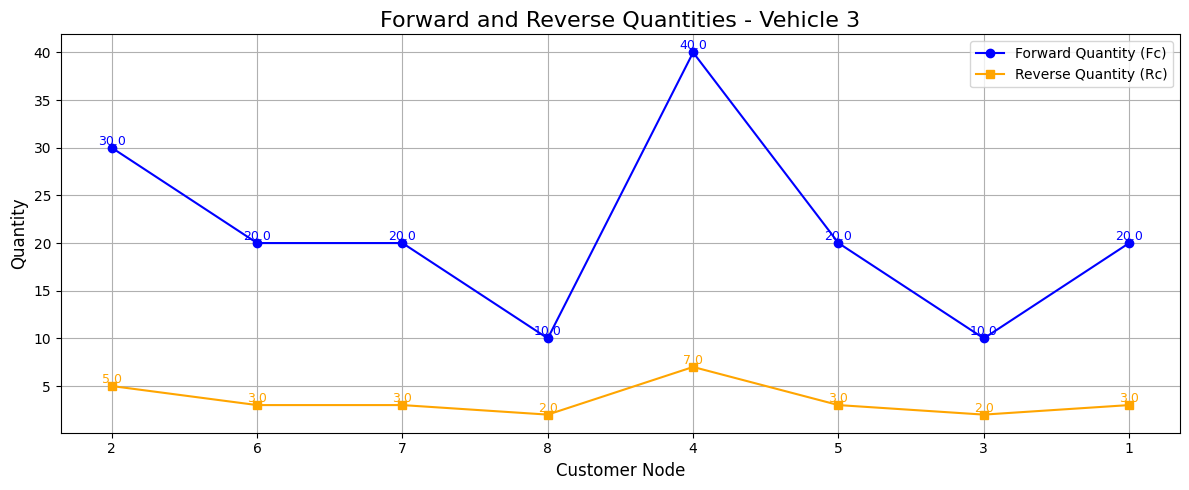

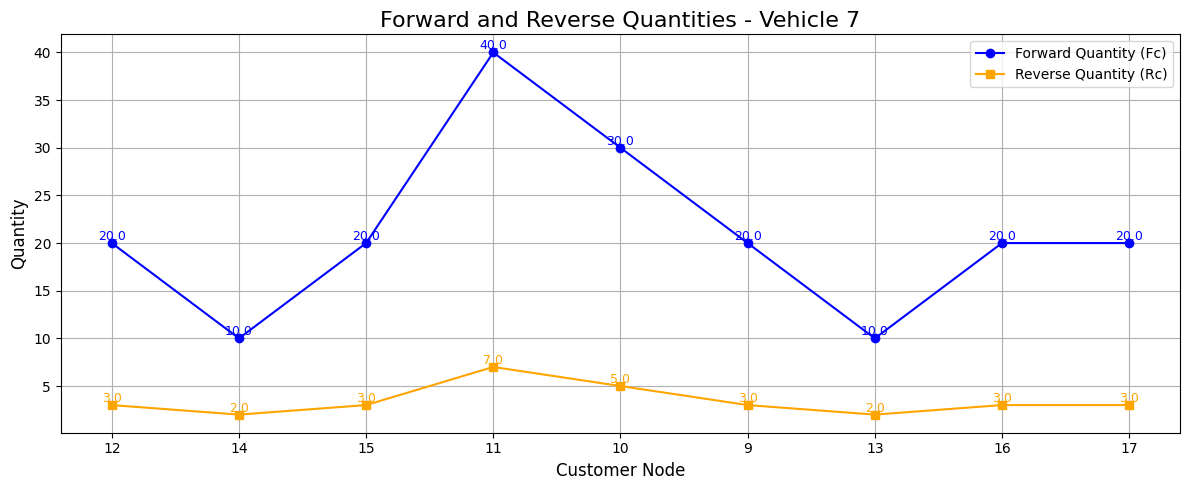

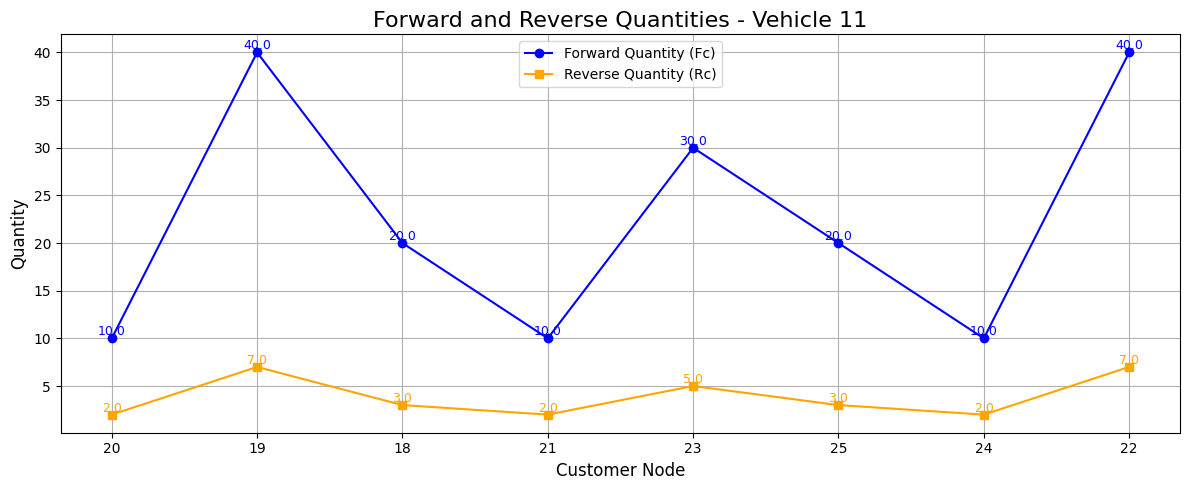

In [4]:
# === Chart ===
import matplotlib.pyplot as plt

for v in V:
    route = [i for (i, j) in sorted(routes[v], key=lambda x: alpha[x[0], v].X) if i in C]
    if len(route) == 0:
        continue

    forward_q = [Fc[i, v].X for i in route]
    reverse_q = [Rc[i, v].X for i in route]
    nodes = [str(i) for i in route]

    plt.figure(figsize=(12, 5))
    plt.plot(nodes, forward_q, marker='o', label='Forward Quantity (Fc)', color='blue')
    plt.plot(nodes, reverse_q, marker='s', label='Reverse Quantity (Rc)', color='orange')

    # Annotate points with values
    for idx, val in enumerate(forward_q):
        plt.text(nodes[idx], val, f'{val:.1f}', ha='center', va='bottom', fontsize=9, color='blue')
    for idx, val in enumerate(reverse_q):
        plt.text(nodes[idx], val, f'{val:.1f}', ha='center', va='bottom', fontsize=9, color='orange')

    plt.title(f'Forward and Reverse Quantities - Vehicle {v}', fontsize=16)
    plt.xlabel('Customer Node', fontsize=12)
    plt.ylabel('Quantity', fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [5]:
# === Update dataset for next period ===

data_updated = data.copy()

num_customers = len(C)

# === Aggregate total satisfied forward demand per customer (sum over all vehicles) ===
Fc_total = []
for i in C:
    total_fc = sum(Fc[i, v].X for v in V)
    Fc_total.append(total_fc)

# === Collect unsatisfied demands ===
Qd_vals = [Qd[i].X for i in C]  # forward unsatisfied
Qr_vals = [Qr[i].X for i in C]  # reverse unsatisfied

# Insert 0 for depot at index 0
Fc_total.insert(0, 0.0)
Qd_vals.insert(0, 0.0)
Qr_vals.insert(0, 0.0)

# === Add new columns to the dataset ===
data_updated["SATISFIED_FWD"] = Fc_total
data_updated["UNSATISFIED_FWD"] = Qd_vals
data_updated["UNSATISFIED_REV"] = Qr_vals

# === Print updated dataset ===
print("\n=== Updated Dataset with Info for Current Period ===")
print(data_updated.to_string(index=False))

data_updated.to_csv("RC104_update.txt", sep='\t', index=False)




=== Updated Dataset with Info for Current Period ===
 CUST_NO  XCOORD  YCOORD  DEMAND  READY_TIME  DUE_DATE  SERVICE_TIME  SATISFIED_FWD  UNSATISFIED_FWD  UNSATISFIED_REV
       0      40      50       0           0       240             0            0.0              0.0              0.0
       1      25      85      20           0       191            10           20.0              0.0              0.0
       2      22      75      30           0       199            10           30.0              0.0              0.0
       3      22      85      10           0       190            10           10.0              0.0              0.0
       4      20      80      40         141       171            10           40.0              0.0              0.0
       5      20      85      20           0       189            10           20.0              0.0              0.0
       6      18      75      20           0       196            10           20.0              0.0              0.0
  